Image Classifier Part 2
~ MLP and Deep Convolutional Networks ~
===========================

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn

# Check if GPU is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np
import glob
import cv2

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

Running code @ cpu


## Fashion-MNIST

### 1.  MLP on extracted attributes

#### Data Preparation

* **Fashion-MNIST** is the equivalent of MNIST dataset for gray images with clothing items. 

* it contains 60k images made of 10 classes: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

* train: 60k; test: 10k

* every image has 16 attributes extracted using first HOG, then PCA over it with 20PC, and last a selector with 80%


In [11]:
# Prepare data
import torch
from torch.utils.data import Dataset

# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 256  #@param
BATCH_SIZE_TEST = 256  #@param
NO_WORKERS = 0  #@param
SHUFFLE_DATA = True  #@param
NUM_CLASSES = 10  # @param

# General parameters
flag_batch_norm = 'ON'  # @param['ON', 'OFF']
flag_regularize = True     # @param['True', 'False'] {type:"raw"}

In [3]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensors
        self.targets = torch.tensor(labels, dtype=torch.long)  # Convert to PyTorch tensors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [173]:
# Load fashion attributes
train_images = np.load('data/fashion/X_train20_scaled.npy')
y_train = np.load('data/fashion/y_train.npy')
test_images = np.load('data/fashion/X_test20_scaled.npy')
y_test = np.load('data/fashion/y_test.npy')

# Normalize
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Size of training images torch.Size([60000, 16])
Size of training labels 60000
Size of test images torch.Size([10000, 16])
Size of test labels 10000


#### Visualize Images

In [99]:
MAX_IMAGES = 10

def gallery(images, label, title='Input images'):
    class_dict = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    images = images.reshape(60000, 28, 28)
    images = images.reshape(60000, 28, 28, 1)
    print(images.shape)
    num_frames, h, w, num_channels = images.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [], 
                                                                                'yticks': []})
    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        axes[i].set_title(class_dict[label[i]])
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()

(60000, 784)
(60000, 28, 28, 1)


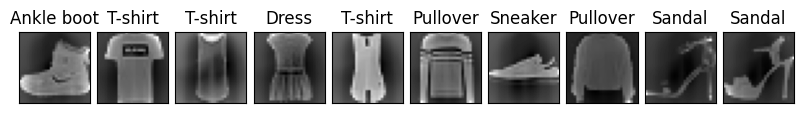

In [100]:
X_train = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
print(X_train.shape)
gallery(X_train, y_train)

#### Prepare Data

In [174]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')


Shape of training images: torch.Size([256, 16])
Shape of training labels: torch.Size([256])


In [17]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of test images: torch.Size([256, 784])
Shape of test labels: torch.Size([256])


#### Define MLP

Architecture:
  * FC(16, 256) + ReLU
  * FC(256, 256) + ReLU
  * FC(256, 10)

In [5]:
class MLP(nn.Module):
    def __init__(self, num_classes=10, in_size=16):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(in_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Define Model and Evaluation Functions

In [176]:
net = None                       # type: nn.Module
mlp_net = MLP(num_classes=NUM_CLASSES)
    
mlp_net.train()               # Default after init is train
mlp_net = mlp_net.to(device)      # Move network to device

print(list(mlp_net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


MLP(
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[-0.1116,  0.0170, -0.0315, -0.2364, -0.0464, -0.1267,  0.0185, -0.2393,
         -0.1067, -0.0104],
        [-0.0913, -0.1250, -0.0262, -0.1826, -0.1532, -0.0434,  0.0519, -0.1562,
         -0.1039, -0.1839]], grad_fn=<AddmmBackward0>)
tensor([6, 6])
tensor([7, 7])


In [5]:
# Get number of parameters in a model by iterating through the model parameters
def get_num_params(model):
    num_params = 0
    for params in model.parameters():
        num_params += params.shape.numel()
        
    return num_params


In [177]:
# Get number of parameters in the model. Verify that we have implemented models correctly
print("Total number of parameters of models")
print(str(mlp_net.__class__), ": ", get_num_params(mlp_net))  

Total number of parameters of models
<class '__main__.MLP'> :  72714


In [18]:
def top_k_accuracy(k, target, output):
    batch_size = target.size(0)
    
    _, pred = output.topk(k, 1, True, True)
    
    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    
    return correct_k


##### Define Optimizer

In [20]:
lr_init = 0.0001             # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-3  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

In [178]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

##### Accuracy and Loss Plotting

In [19]:
# Function that takes a list of losses and plots them.
REFRESH_EVERY = 1000

# Funcție pentru afișarea a două grafice: unul pentru eroare și unul pentru acuratețe
def plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracies, test_accuracies, steps, ct):
    print(f'Step {ct}')
    
    # print all loss and accuracy
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)
    
    display.display(plt.gcf())
    plt.clf()  # Șterge graficul anterior
    
    # Configurare subploturi
    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Graficul pentru pierderi (loss)
    axs[0].plot(steps, train_losses, c='b', label='Train Loss')  # Albastru pentru eroarea de antrenare
    axs[0].plot(steps, test_losses, c='r', label='Test Loss')    # Roșu pentru eroarea de test
    axs[0].set_title('Loss Over Steps')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    # Graficul pentru acuratețe (accuracy)
    axs[1].plot(steps, train_accuracies, c='b', linestyle='--', label='Train Accuracy')  # Albastru pentru acuratețea de antrenare
    axs[1].plot(steps, test_accuracies, c='r', linestyle='--', label='Test Accuracy')  # Roșu pentru acuratețea de test
    axs[1].set_title('Accuracy Over Steps')
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='upper right')
    
    plt.tight_layout()  # Ajustează spațiile dintre subploturi
    plt.show()

##### Model Evaluation

In [24]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# Funcție pentru calculul metricilor
def evaluate_model(net, loader, device):
    net.eval()  # Setăm modelul în modul de evaluare
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            preds = torch.argmax(outputs, axis=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculăm metricile
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    
    return precision, recall, f1, accuracy

# Date pentru diferite experimente
results = []

##### Define Training Parameters

In [21]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e3  # @param
REPORT_TRAIN_EVERY = 100  # @param
PLOT_EVERY = 100  # @param
REPORT_TEST_EVERY = 100  # @param
TEST_ITERS = 100  # @param

#### Train and Evaluate Model

In [15]:
def train_mlp(train_dataset_size, batch_size_train, train_loader, test_loader, net, lr_scheduler, optimizer, epochs=200):
    train_iter = 0
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    steps = []

    # simulate an inifinte test data provider by looping over the test data
    test_data_provider = loopy_test_loader(test_loader)

    # set model in train mode
    net.train()

    running_loss = 0.0
    running_acc = 0.0
    ct = 0

    for epoch in range(int(epochs)):  # loop over the dataset multiple times
        
        for i, data in enumerate(train_loader, 0):
            # set the learning rate and decay according to iteration schedule
            lr_scheduler.step()
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += top_k_accuracy(1, labels, outputs)
            
            if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
                train_loss = running_loss / REPORT_TRAIN_EVERY
                train_acc = running_acc / REPORT_TRAIN_EVERY
                
                print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
                print('[%d, %5d] loss: %.5f, acc: %.5f' %
                    (epoch + 1, i + 1, train_loss, train_acc))
                
                train_losses.append(train_loss)
                train_accuracy.append(train_acc.item())
                steps.append(train_iter)
                
                running_loss = 0
                train_loss = 0
                train_acc = 0
                running_acc = 0
                
            if train_iter % PLOT_EVERY == 0:
                # plot_losses(losses, acc, steps, train_iter)
                plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracy, test_accuracy, steps, train_iter)
                
            train_iter += 1
        
            if train_iter % REPORT_TEST_EVERY == 0:
                # set model in test mode
                net.eval()
                
                with torch.no_grad():
                    # evaluate over at most TEST_ITER sub samples from the test_loader
                    test_iter = 0
                    test_loss = 0
                    correct = 0
                    
                    while test_iter < TEST_ITERS:
                    # for j, test_data in enumerate(test_loader, start=test_ct):
                        test_data = next(test_data_provider)
                            
                        # get the test inputs; data is a list of [inputs, labels]
                        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                        
                        out = net(test_inputs)
                        test_loss += criterion(out, test_labels)
                        
                        
                        correct += top_k_accuracy(1, test_labels, out)
                        
                        test_iter += 1
                        
                    avg_test_loss = test_loss / TEST_ITERS
                    avg_acc = correct / TEST_ITERS

                    test_losses.append(avg_test_loss.item())
                    test_accuracy.append(avg_acc.item())
                    
                    print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                        % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                    
                # set model back in train mode
                net.train()

    print('Finished Training')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

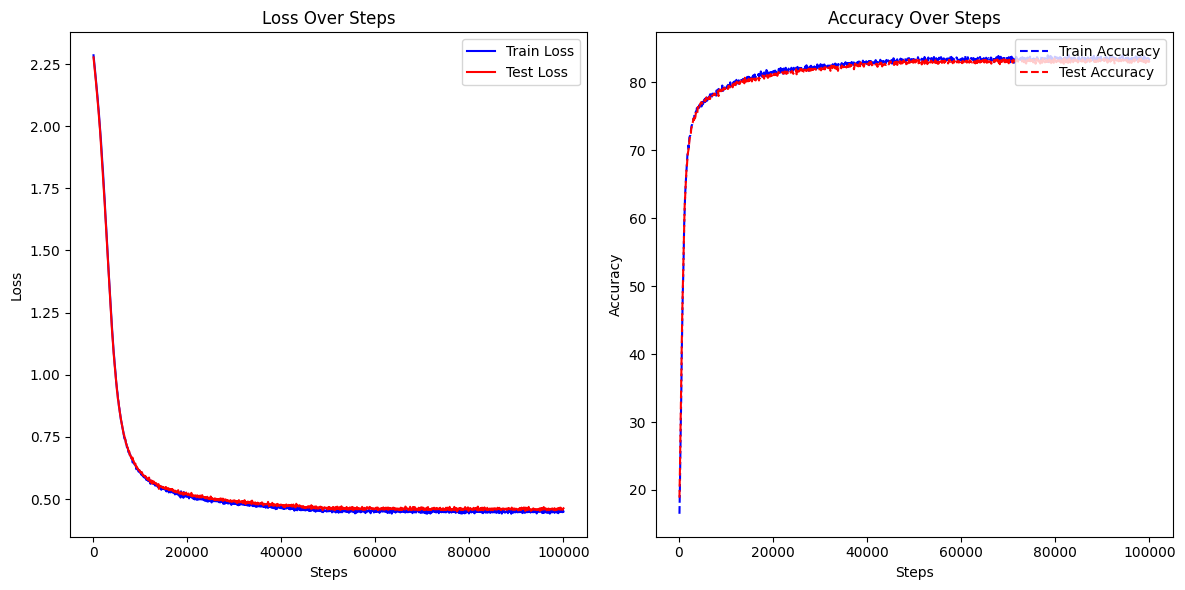

[426,   225, 100099] LR: 0.00000
[426,   225] loss: 0.44552, acc: 83.53516
[426,   225] avg_test_loss: 0.45428, avg_test_acc: 83.32
Step 100100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

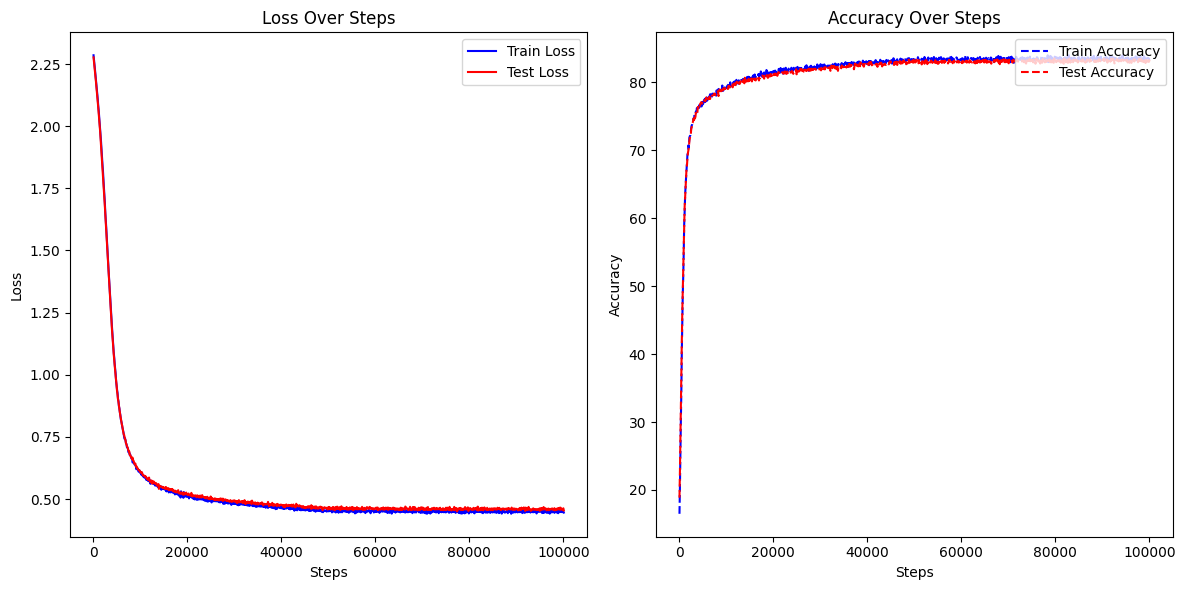

Finished Training


In [179]:
train_mlp(60000, BATCH_SIZE_TRAIN, train_loader=train_loader, test_loader=test_loader,
         net=mlp_net, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [181]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "HOG-PCA20 Attributes"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_net, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100
Fashion-MNIST,Liniarized Images,MLP,Test,0.860365,0.861300,0.860445,0.861300
Fashion-MNIST,HOG-PCA20 Attributes,MLP,Test,0.830739,0.831500,0.830838,0.831500


In [182]:
results_df.to_csv('results.csv', index=False)

### 2. MLP on Images

#### Load Data

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

DATA_MEAN = (0.5,)
DATA_STD = (0.5,)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),     # Convert to tensor and scale to [0, 1]
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD),  # Normalize for RGB channels
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to a 1D tensor
])

# Load the dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Test the output
images, labels = next(iter(train_loader))
print(images.size())
print(labels.size())

images, labels = next(iter(test_loader))
print(images.size())
print(labels.size())

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

torch.Size([256, 784])
torch.Size([256])
torch.Size([256, 784])
torch.Size([256])
Shape of training images: torch.Size([256, 784])
Shape of training labels: torch.Size([256])


#### Define Model and Optimizer

In [7]:
net = None                       # type: nn.Module
mlp_net2 = MLP(num_classes=10, in_size=(28 * 28))
    
mlp_net2.train()               # Default after init is train
mlp_net2 = mlp_net2.to(device)      # Move network to device

print(list(mlp_net2.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_net2(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[-0.0417, -0.0529, -0.0772,  0.0198,  0.1284,  0.0420,  0.1082, -0.0348,
          0.0690,  0.0696],
        [-0.0549, -0.0655, -0.0197,  0.0348, -0.0056,  0.0320,  0.0907,  0.0793,
          0.0194,  0.0667]], grad_fn=<AddmmBackward0>)
tensor([4, 6])
tensor([9, 6])


In [14]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

lr_init = 0.001
weight_decay_factor = 1e-3
lr_factor = 0.1
lr_schedule_milestones = [50e3, 75e3, 100e3]

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_net2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_net2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

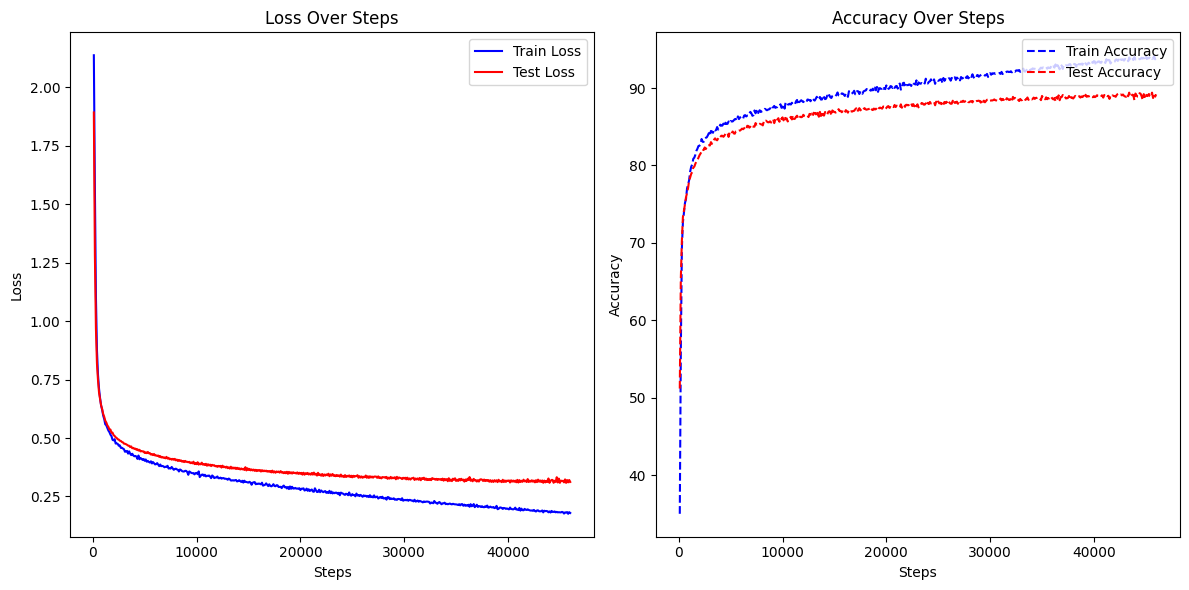

[197,    40,  46099] LR: 0.00100
[197,    40] loss: 0.17663, acc: 94.00000
[197,    40] avg_test_loss: 0.31811, avg_test_acc: 88.83
Step 46100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

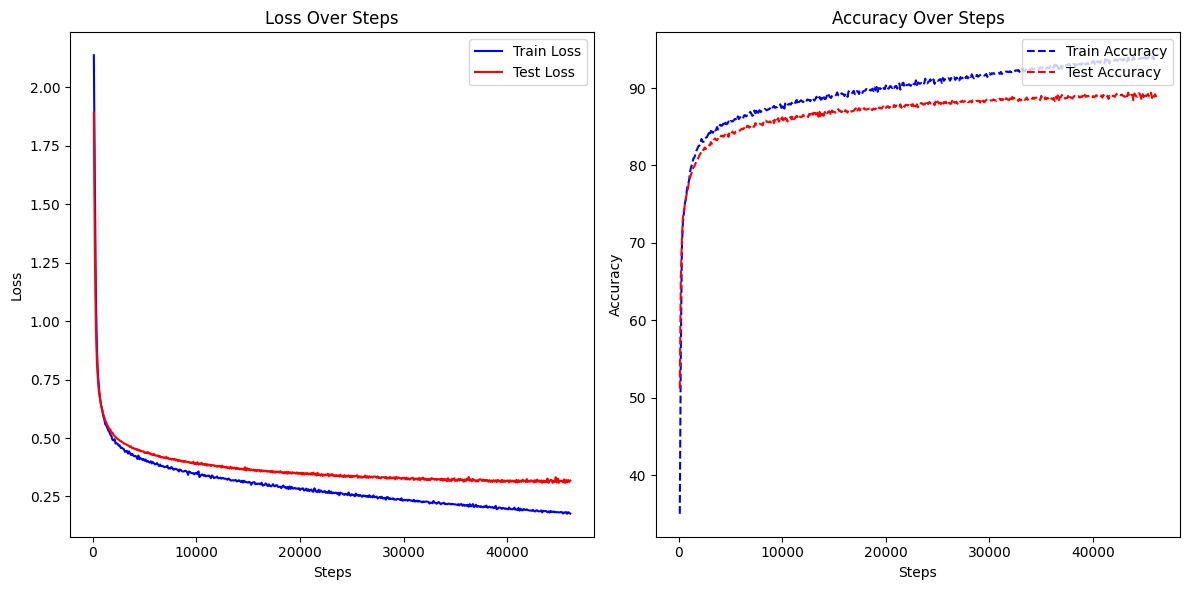

[197,   140,  46199] LR: 0.00100
[197,   140] loss: 0.17406, acc: 94.32812
[197,   140] avg_test_loss: 0.31496, avg_test_acc: 88.88
Step 46200


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

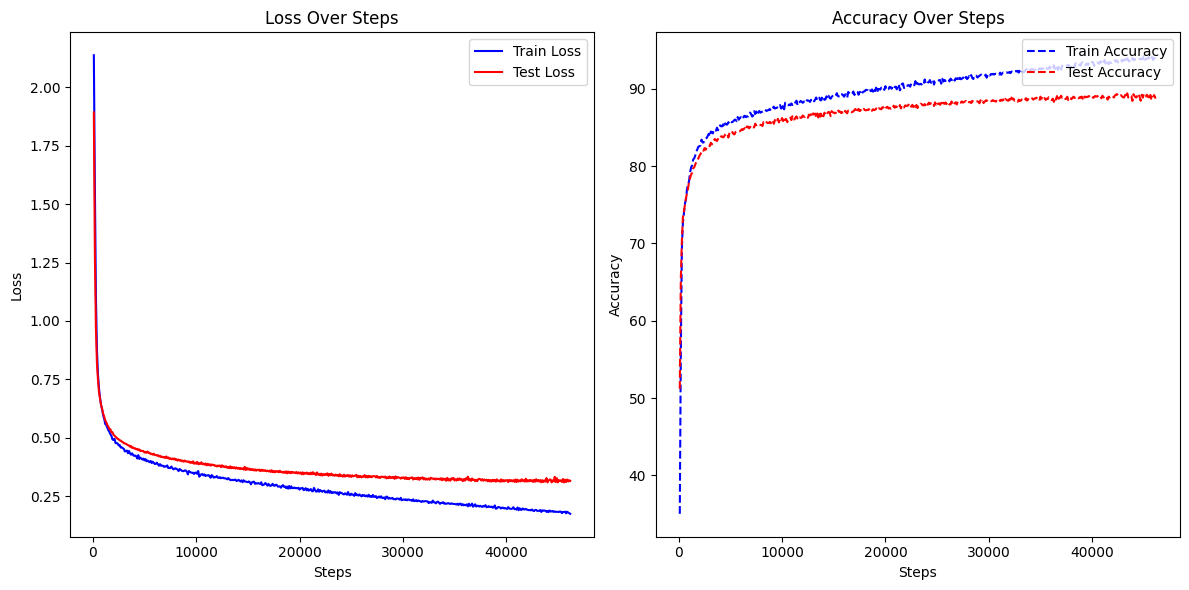

[198,     5,  46299] LR: 0.00100
[198,     5] loss: 0.18176, acc: 93.94531
[198,     5] avg_test_loss: 0.31687, avg_test_acc: 89.18
Step 46300


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

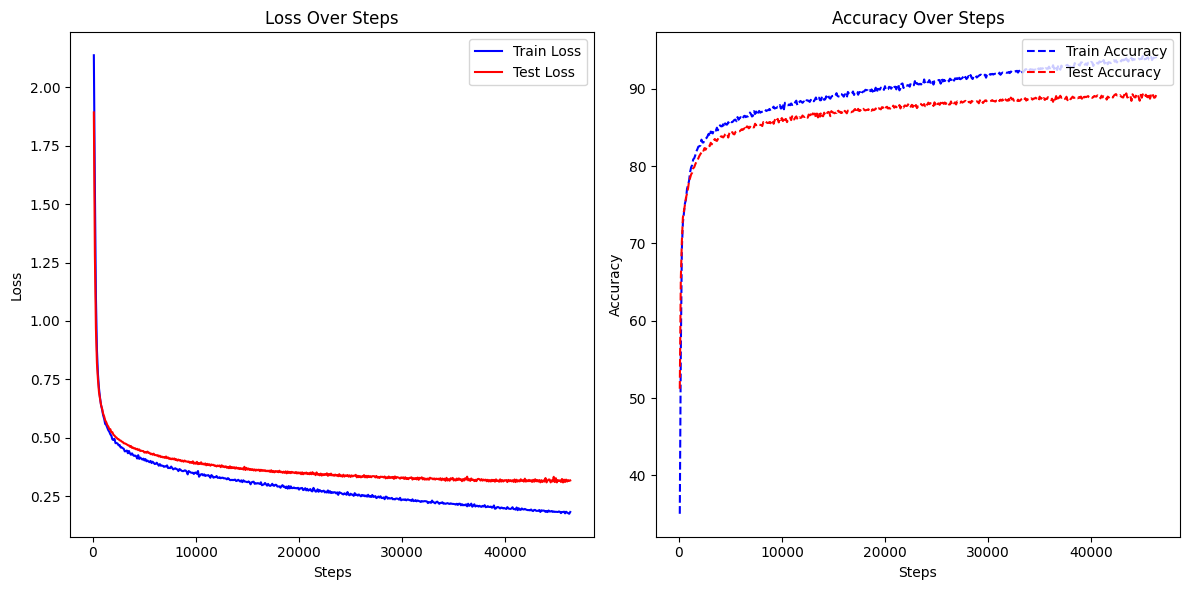

[198,   105,  46399] LR: 0.00100
[198,   105] loss: 0.17628, acc: 94.20703
[198,   105] avg_test_loss: 0.30887, avg_test_acc: 89.46
Step 46400


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

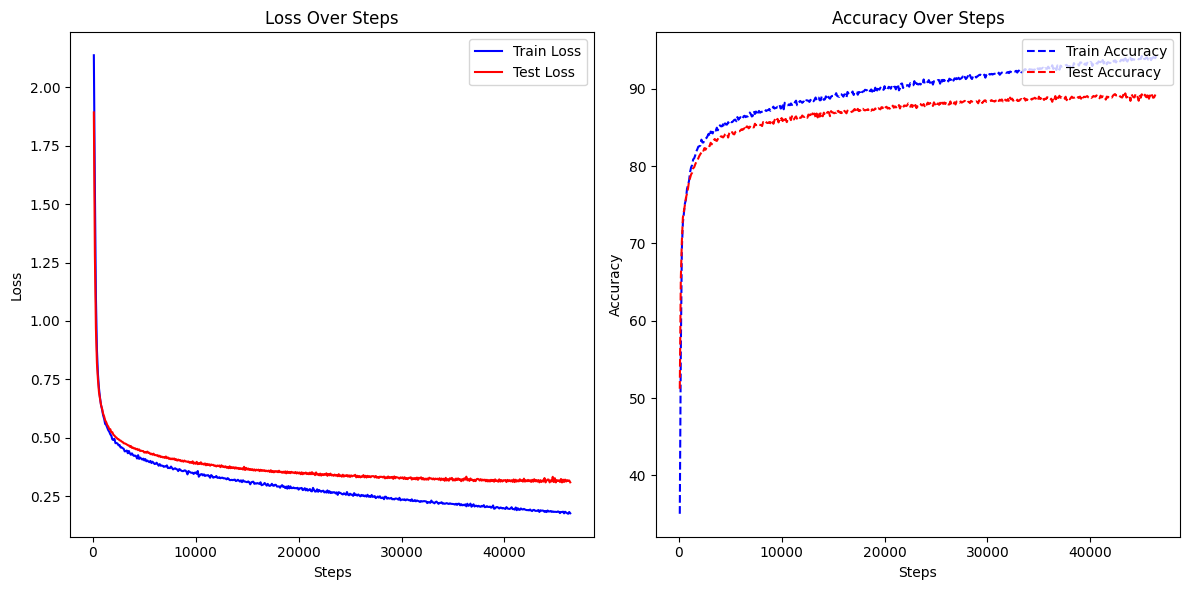

[198,   205,  46499] LR: 0.00100
[198,   205] loss: 0.17682, acc: 94.16797
[198,   205] avg_test_loss: 0.31563, avg_test_acc: 89.07
Step 46500


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

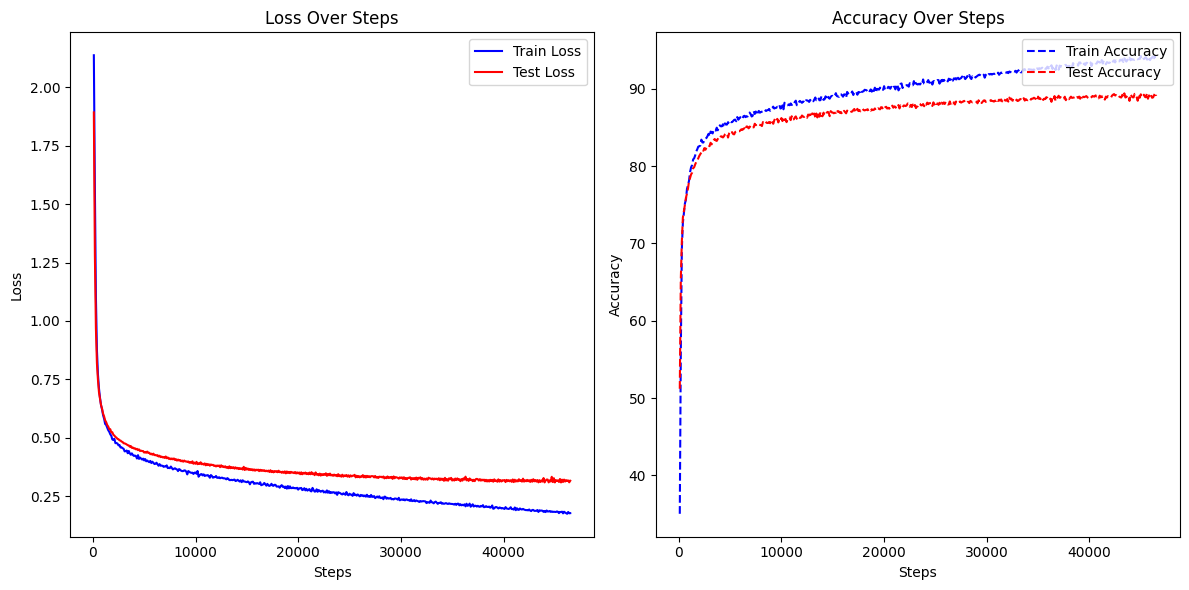

[199,    70,  46599] LR: 0.00100
[199,    70] loss: 0.17769, acc: 93.96745
[199,    70] avg_test_loss: 0.30861, avg_test_acc: 89.22
Step 46600


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

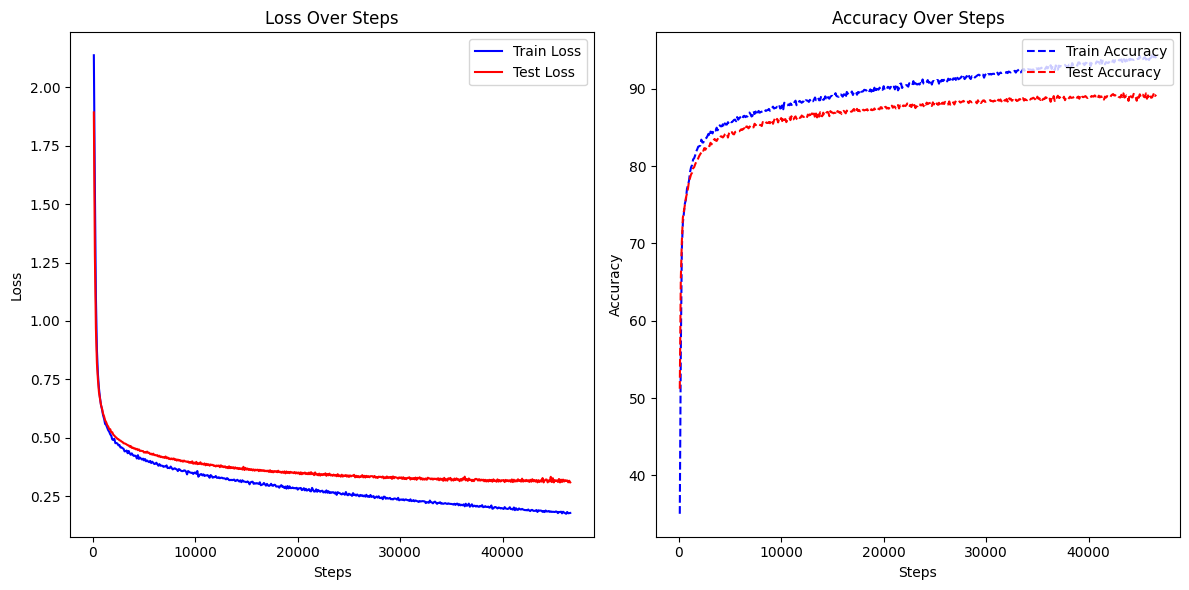

[199,   170,  46699] LR: 0.00100
[199,   170] loss: 0.17725, acc: 94.28125
[199,   170] avg_test_loss: 0.31799, avg_test_acc: 89.04
Step 46700


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

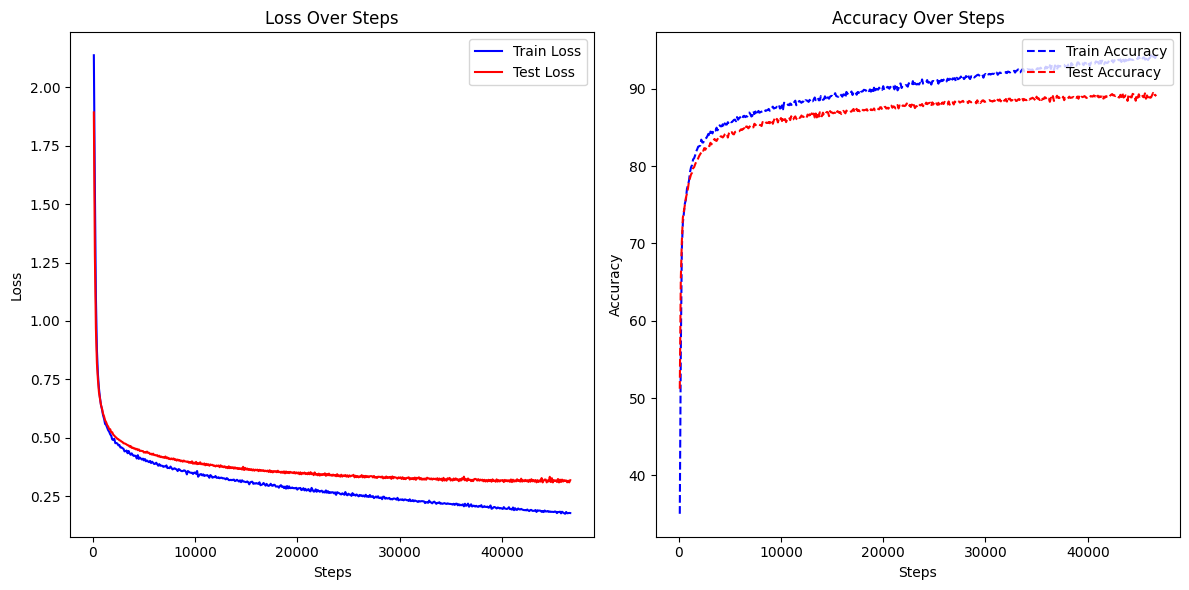

[200,    35,  46799] LR: 0.00100
[200,    35] loss: 0.17943, acc: 93.87891
[200,    35] avg_test_loss: 0.31030, avg_test_acc: 89.27
Step 46800


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

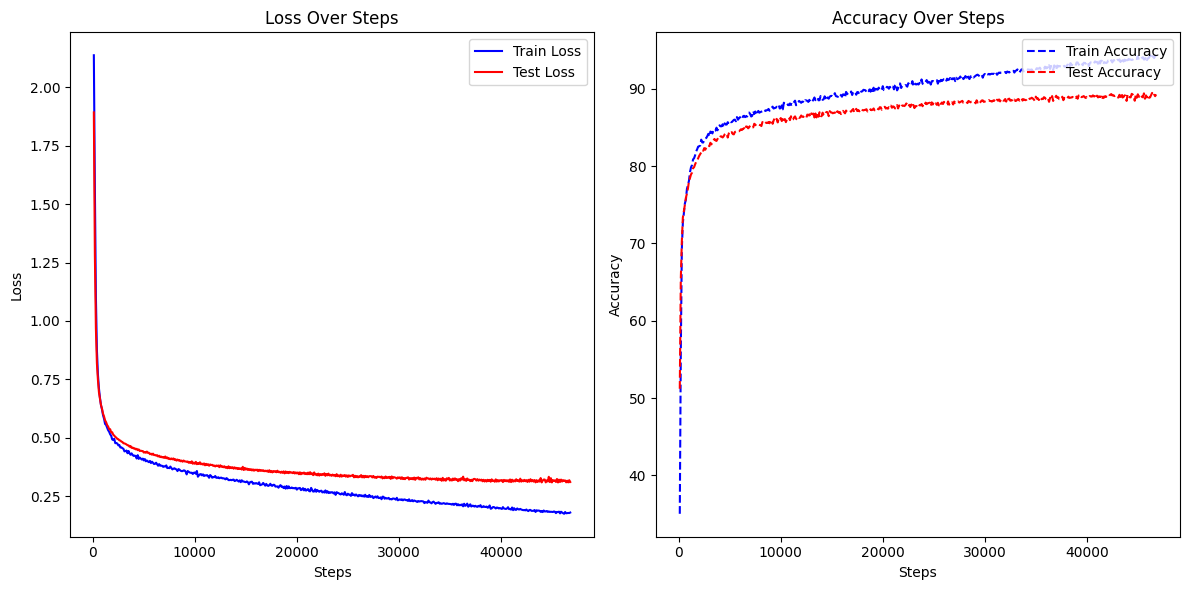

[200,   135,  46899] LR: 0.00100
[200,   135] loss: 0.17637, acc: 94.13281
[200,   135] avg_test_loss: 0.32205, avg_test_acc: 88.80
Step 46900


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

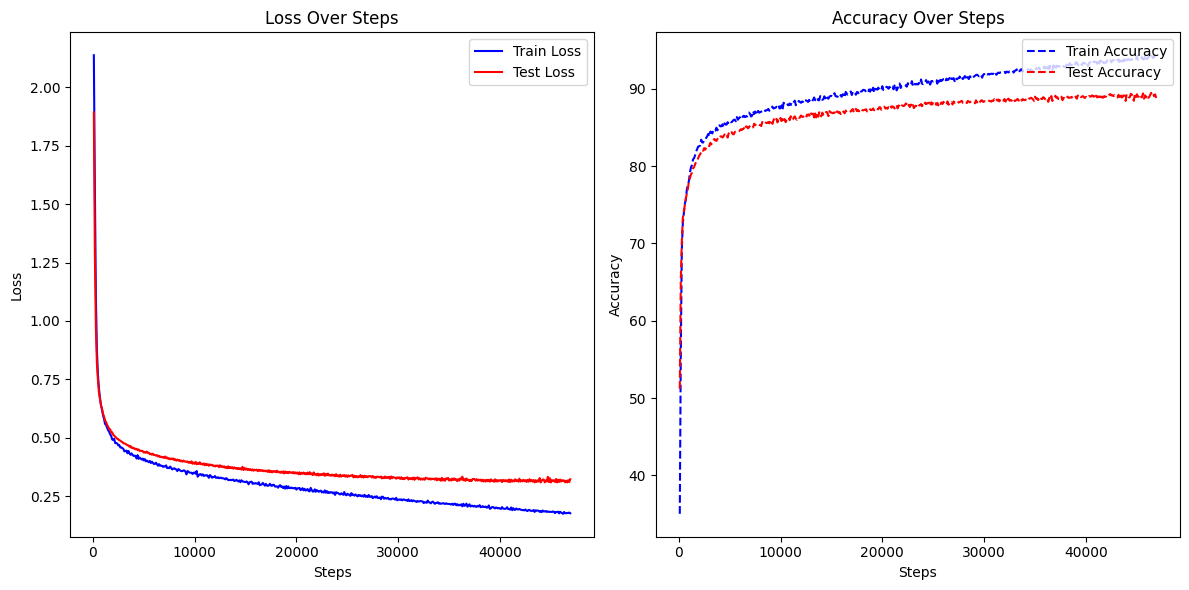

[200,   235,  46999] LR: 0.00100
[200,   235] loss: 0.17629, acc: 94.17317
[200,   235] avg_test_loss: 0.30998, avg_test_acc: 89.20
Finished Training


In [22]:
train_mlp(60000, BATCH_SIZE_TRAIN, train_loader=train_loader, test_loader=test_loader,
         net=mlp_net2, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [26]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_net2, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_net2, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,MLP,Test,0.890001,0.890500,0.889791,0.890500


In [27]:
results_df.to_csv('results2.csv', index=False)

### 3. DeepConvNet on Images

#### Load Data without Augmentation

In [29]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

DATA_MEAN = (0.5,)
DATA_STD = (0.5,)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),     # Convert to tensor and scale to [0, 1]
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)  # Normalize for RGB channels
    
])

# Load the dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Test the output
images, labels = next(iter(train_loader))
print(images.size())
print(labels.size())

images, labels = next(iter(test_loader))
print(images.size())
print(labels.size())

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

torch.Size([256, 1, 32, 32])
torch.Size([256])
torch.Size([256, 1, 32, 32])
torch.Size([256])
Shape of training images: torch.Size([256, 1, 32, 32])
Shape of training labels: torch.Size([256])


#### Load Data with Augmentation

In [45]:
# Define transformations
train_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),  # Resize images to 32x32
        transforms.RandomHorizontalFlip(),     # apply random horizontal flip
        transforms.RandomRotation(10),         # apply random rotation of 30 degrees
        transforms.RandomCrop(                          # apply random crop, after padding image with 4 values on each side, using `reflect` mode
            size=(32, 32), 
            padding=(4, 4), 
            padding_mode="reflect"),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD)       # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),  # Resize images to 32x32
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD) 
    ]
)

# Load the dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Create data loaders
train_loader_aug = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader_aug = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Test the output
images, labels = next(iter(train_loader_aug))
print(images.size())
print(labels.size())

images, labels = next(iter(test_loader_aug))
print(images.size())
print(labels.size())

# get a training batch of images and labels
(batch_train_images_aug, batch_train_labels_aug) = next(iter(train_loader_aug))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images_aug.size()}')
print(f'Shape of training labels: {batch_train_labels_aug.size()}')

torch.Size([256, 1, 32, 32])
torch.Size([256])
torch.Size([256, 1, 32, 32])
torch.Size([256])
Shape of training images: torch.Size([256, 1, 32, 32])
Shape of training labels: torch.Size([256])


#### Define DeepConvNet Architecture

In [41]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            nn.Dropout2d(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.Linear(in_features=120, out_features=num_classes)
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

In [51]:
# model
net = None                       # type: nn.Module
net = LeNet(in_channels=1)
    
net.train()               # Default after init is train
net = net.to(device)      # Move network to device

print(list(net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

# Test for augmented data
inputs = batch_train_images_aug.to(device)[:select]
target = batch_train_labels_aug[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=120, out_features=10, bias=True)
  )
)
tensor([[-0.0502,  0.0188, -0.0112, -0.0856,  0.0032,  0.0775, -0.1126,  0.1543,
          0.0554, -0.0806],
        [-0.0372, -0.0346,  0.0815,  0.0200, -0.0629,  0.0500, -0.0392,  0.0914,
          0.0710, -0.0180]], grad_fn=<AddmmBackward0>)
tensor([7, 7])
tensor([7, 0])
tensor([[-0.0405,  0.0078,  0.0396, -0.0260, -0.0163, -0.0117, -0.1051,  0.1095,
      

In [52]:
lr_init = 0.001             # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.Adam(net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate Data without Augmentation

In [34]:
def train_lenet(train_dataset_size, batch_size_train, train_loader, test_loader, net, lr_scheduler, optimizer, epochs=200):
    # epochs = int(TRAIN_ITERS / (train_dataset_size / batch_size_train))

    train_iter = 0
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    steps = []

    # simulate an inifinte test data provider by looping over the test data
    test_data_provider = loopy_test_loader(test_loader)

    # set model in train mode
    net.train()

    running_loss = 0.0
    running_acc = 0.0
    ct = 0

    for epoch in range(int(epochs)):  # loop over the dataset multiple times
        
        for i, data in enumerate(train_loader, 0):
            # set the learning rate and decay according to iteration schedule
            lr_scheduler.step()
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += top_k_accuracy(1, labels, outputs)
            
            if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
                train_loss = running_loss / REPORT_TRAIN_EVERY
                train_acc = running_acc / REPORT_TRAIN_EVERY
                
                print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
                print('[%d, %5d] loss: %.5f, acc: %.5f' %
                    (epoch + 1, i + 1, train_loss, train_acc))
                
                train_losses.append(train_loss)
                train_accuracy.append(train_acc.item())
                steps.append(train_iter)
                
                running_loss = 0
                train_loss = 0
                train_acc = 0
                running_acc = 0
                
            train_iter += 1
        
            if train_iter % REPORT_TEST_EVERY == 0:
                # set model in test mode
                net.eval()
                
                with torch.no_grad():
                    # evaluate over at most TEST_ITER sub samples from the test_loader
                    test_iter = 0
                    test_loss = 0
                    correct = 0
                    
                    while test_iter < TEST_ITERS:
                    # for j, test_data in enumerate(test_loader, start=test_ct):
                        test_data = next(test_data_provider)
                            
                        # get the test inputs; data is a list of [inputs, labels]
                        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                        
                        out = net(test_inputs)
                        test_loss += criterion(out, test_labels)
                        
                        
                        correct += top_k_accuracy(1, test_labels, out)
                        
                        test_iter += 1
                        
                    avg_test_loss = test_loss / TEST_ITERS
                    avg_acc = correct / TEST_ITERS

                    test_losses.append(avg_test_loss.item())
                    test_accuracy.append(avg_acc.item())
                    
                    print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                        % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                    
                # set model back in train mode
                net.train()

    print('Finished Training')
    return train_losses, train_accuracy, test_losses, test_accuracy, steps

In [35]:
train_losses, train_accuracies, test_losses, test_accuracies, steps = train_lenet(60000, 256, train_loader=train_loader, test_loader=test_loader,
         net=net, lr_scheduler=lr_scheduler, optimizer=optimizer)

[1,   100,     99] LR: 0.00100
[1,   100] loss: 1.09320, acc: 63.32812
[1,   100] avg_test_loss: 0.71253, avg_test_acc: 72.80
[1,   200,    199] LR: 0.00100
[1,   200] loss: 0.68653, acc: 74.89844
[1,   200] avg_test_loss: 0.59716, avg_test_acc: 78.48
[2,    65,    299] LR: 0.00100
[2,    65] loss: 0.60512, acc: 78.22395
[2,    65] avg_test_loss: 0.55175, avg_test_acc: 79.93
[2,   165,    399] LR: 0.00100
[2,   165] loss: 0.56651, acc: 79.60156
[2,   165] avg_test_loss: 0.50664, avg_test_acc: 81.34
[3,    30,    499] LR: 0.00100
[3,    30] loss: 0.52038, acc: 81.36068
[3,    30] avg_test_loss: 0.49792, avg_test_acc: 81.98
[3,   130,    599] LR: 0.00100
[3,   130] loss: 0.51603, acc: 81.62109
[3,   130] avg_test_loss: 0.46414, avg_test_acc: 83.41
[3,   230,    699] LR: 0.00100
[3,   230] loss: 0.49483, acc: 82.68359
[3,   230] avg_test_loss: 0.45806, avg_test_acc: 83.80
[4,    95,    799] LR: 0.00100
[4,    95] loss: 0.46910, acc: 83.36458
[4,    95] avg_test_loss: 0.43494, avg_test_acc

Step 46999


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

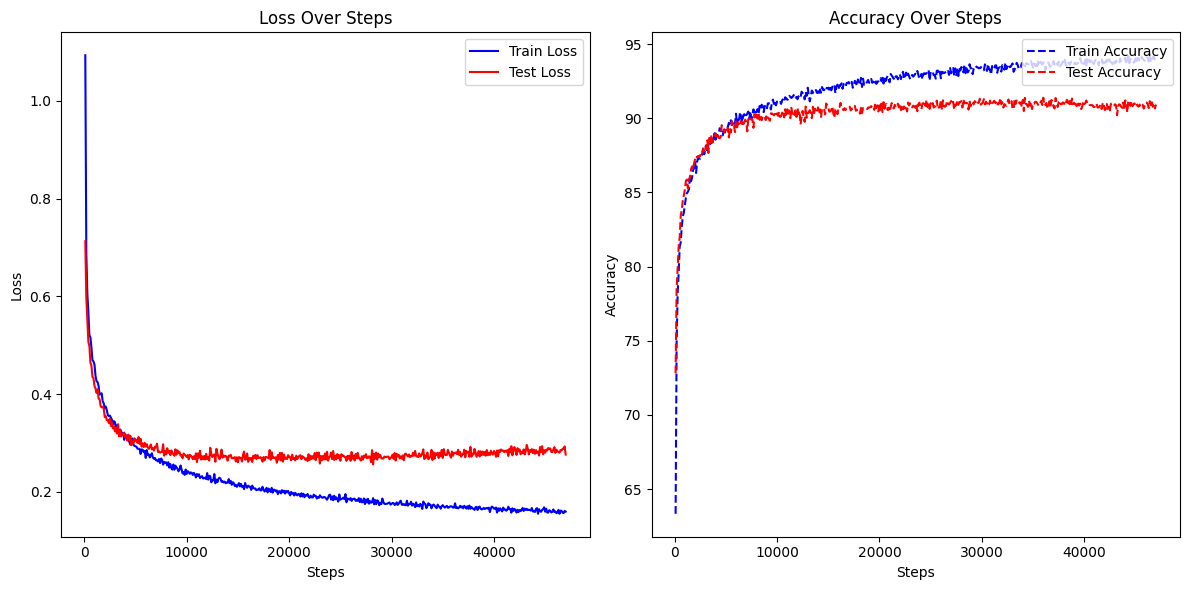

In [36]:
plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracies, test_accuracies, steps, steps[-1])

In [37]:
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "LeNet-5 wihout Augmentation"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(net, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,MLP,Test,0.890001,0.890500,0.889791,0.890500
Fashion-MNIST,Liniarized Images,LeNet-5 wihout Augmentation,Test,0.906556,0.906300,0.906148,0.906300


In [38]:
# saving the dataframe
results_df.to_csv('results2.csv')

In [50]:
# save losses and accuracies
import pickle
np.save('lenet_without_aug_losses.npy', [train_losses, train_accuracies, test_losses, test_accuracies, steps])

#### Train and Evaluate Data with Augmentation

In [53]:
train_losses_aug, train_accuracy_aug, test_losses_aug, test_accuracy_aug, steps_aug = train_lenet(60000, 256, train_loader=train_loader_aug, test_loader=test_loader_aug,
         net=net, lr_scheduler=lr_scheduler, optimizer=optimizer)

[1,   100,     99] LR: 0.00100
[1,   100] loss: 1.43041, acc: 48.14844
[1,   100] avg_test_loss: 0.90324, avg_test_acc: 65.72
[1,   200,    199] LR: 0.00100
[1,   200] loss: 1.01760, acc: 62.66016
[1,   200] avg_test_loss: 0.78626, avg_test_acc: 70.89
[2,    65,    299] LR: 0.00100
[2,    65] loss: 0.91461, acc: 66.27995
[2,    65] avg_test_loss: 0.74298, avg_test_acc: 71.32
[2,   165,    399] LR: 0.00100
[2,   165] loss: 0.87013, acc: 67.69531
[2,   165] avg_test_loss: 0.69868, avg_test_acc: 73.61
[3,    30,    499] LR: 0.00100
[3,    30] loss: 0.83648, acc: 69.38672
[3,    30] avg_test_loss: 0.68601, avg_test_acc: 72.84
[3,   130,    599] LR: 0.00100
[3,   130] loss: 0.80778, acc: 70.10547
[3,   130] avg_test_loss: 0.66217, avg_test_acc: 74.71
[3,   230,    699] LR: 0.00100
[3,   230] loss: 0.77699, acc: 71.36719
[3,   230] avg_test_loss: 0.64455, avg_test_acc: 75.88
[4,    95,    799] LR: 0.00100
[4,    95] loss: 0.76490, acc: 71.62891
[4,    95] avg_test_loss: 0.62950, avg_test_acc

Step 46999


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

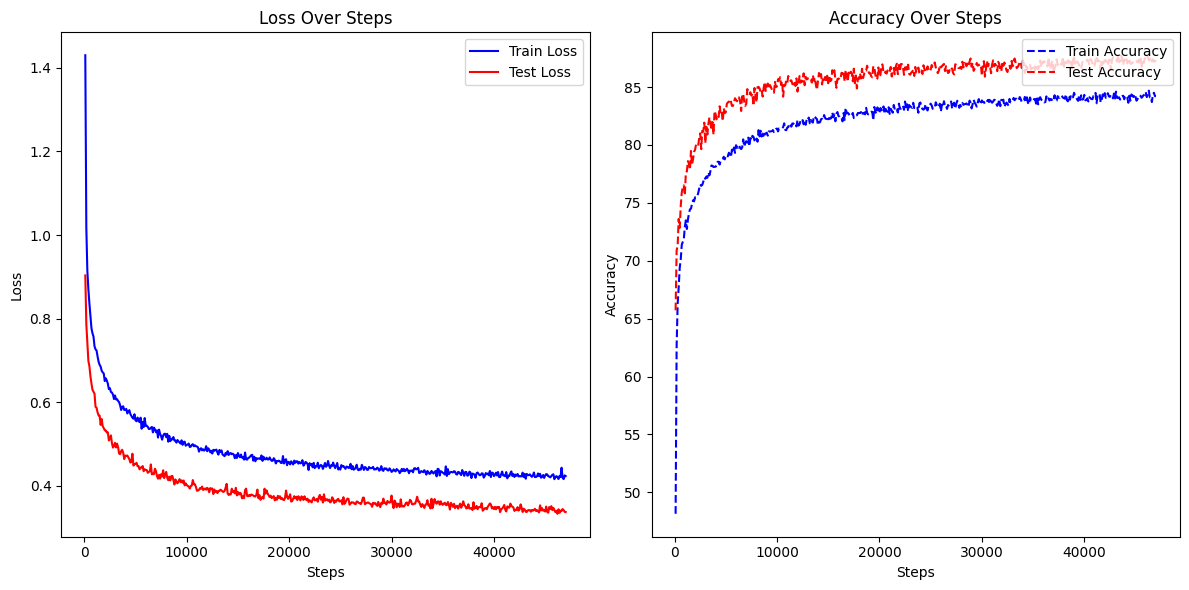

In [54]:
plot_loss_and_accuracy_side_by_side(train_losses_aug, test_losses_aug, train_accuracy_aug, test_accuracy_aug, steps_aug, steps_aug[-1])

In [55]:
# Evaluate model with data augmentation
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "LeNet-5 with Augmentation"

# Calculate metrics for training and test sets
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(net, test_loader, device)

# Add results to table
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the full table
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,MLP,Test,0.890001,0.890500,0.889791,0.890500
Fashion-MNIST,Liniarized Images,LeNet-5 wihout Augmentation,Test,0.906556,0.906300,0.906148,0.906300
Fashion-MNIST,Liniarized Images,LeNet-5 with Augmentation,Test,0.875513,0.875500,0.875132,0.875500


In [56]:
results_df.to_csv('results2.csv', index=False)
np.save('lenet_with_aug_losses.npy', [train_losses_aug, train_accuracy_aug, test_losses_aug, test_accuracy_aug, steps_aug])

In [60]:
print(train_accuracy_aug)
print(test_accuracy_aug)

[48.1484375, 62.66015625, 66.27995300292969, 67.6953125, 69.38671875, 70.10546875, 71.3671875, 71.62890625, 71.84765625, 72.92707824707031, 73.48828125, 72.73958587646484, 73.5546875, 74.05859375, 74.44010925292969, 74.4921875, 74.9140625, 75.21484375, 75.125, 75.4765625, 75.453125, 75.54296875, 75.82421875, 76.19010925292969, 76.58984375, 76.46614837646484, 76.546875, 76.8046875, 77.17708587646484, 77.08203125, 77.26171875, 77.16015625, 77.6171875, 77.37109375, 77.7421875, 78.22786712646484, 78.19140625, 78.09375, 78.11328125, 78.11197662353516, 78.22265625, 78.54296875, 78.54426574707031, 78.3046875, 78.62630462646484, 78.7265625, 78.79166412353516, 78.9765625, 78.75390625, 79.10546875, 79.03125, 79.02083587646484, 79.32421875, 79.1796875, 78.94660949707031, 79.59375, 79.40495300292969, 79.77734375, 79.31380462646484, 79.9765625, 79.78515625, 79.75910949707031, 79.98046875, 79.73046875, 79.640625, 79.78255462646484, 80.4765625, 79.859375, 80.13802337646484, 80.3203125, 80.20051574707

#### Plot Comparative Results

In [57]:
def plot_comparative_results(train_losses, test_losses, train_accuracies, test_accuracies, steps,
                              train_losses_aug, test_losses_aug, train_accuracy_aug, test_accuracy_aug, steps_aug):
    # print(f'Step {ct}')
    
    # print all loss and accuracy
    # if ct % REFRESH_EVERY == 0:
    #     display.clear_output(wait=True)
    
    display.display(plt.gcf())
    plt.clf()  # Șterge graficul anterior
    
    # Configurare subploturi
    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Graficul pentru pierderi (loss)
    axs[0].plot(steps, train_losses, c='b', label='Train Loss')  # Albastru pentru eroarea de antrenare
    axs[0].plot(steps, test_losses, c='r', label='Test Loss')    # Roșu pentru eroarea de test
    axs[0].plot(steps, train_losses_aug, c='g', label='Train Loss with Augmentation')  # Albastru pentru eroarea de antrenare
    axs[0].plot(steps, test_losses_aug, c='orange', label='Test Loss with Augmentation')    # Roșu pentru eroarea de test
    axs[0].set_title('Loss Over Steps')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    # Graficul pentru acuratețe (accuracy)
    axs[1].plot(steps, train_accuracies, c='b', linestyle='--', label='Train Accuracy')  # Albastru pentru acuratețea de antrenare
    axs[1].plot(steps, test_accuracies, c='r', linestyle='--', label='Test Accuracy')  # Roșu pentru acuratețea de test
    axs[1].plot(steps_aug, train_accuracy_aug, c='g', linestyle='--', label='Train Accuracy with Augmentation')
    axs[1].plot(steps_aug, test_accuracy_aug, c='orange', linestyle='--', label='Test Accuracy with Augmentation')
    axs[1].set_title('Accuracy Over Steps')
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='upper right')
    
    plt.tight_layout()  # Ajustează spațiile dintre subploturi
    plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

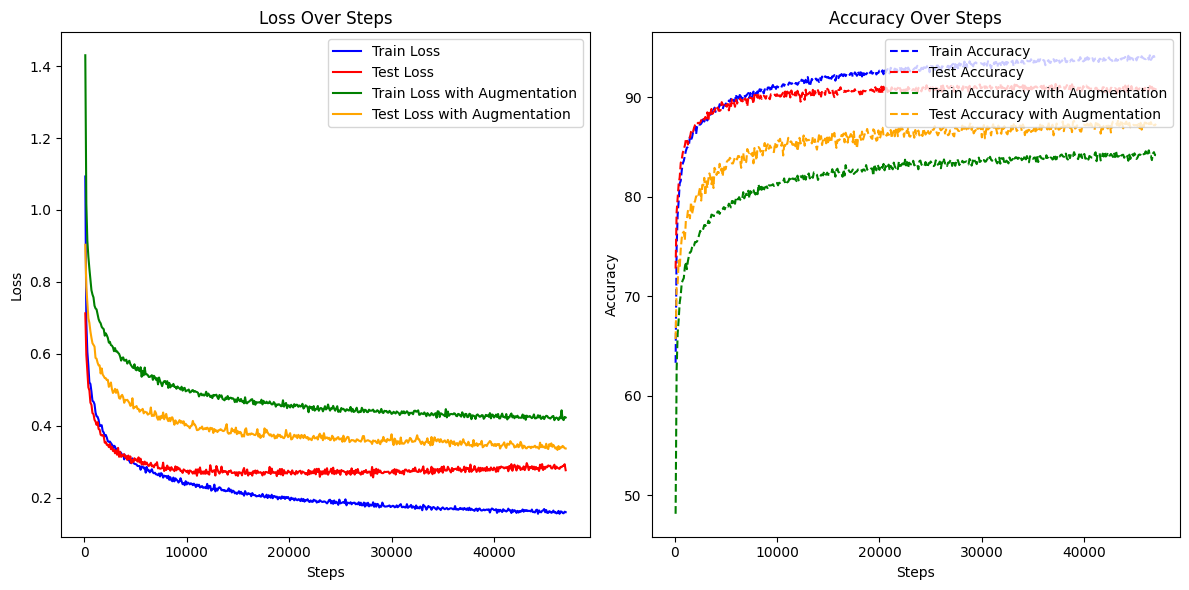

In [58]:
plot_comparative_results(train_losses, test_losses, train_accuracies, test_accuracies, steps,
                            train_losses_aug, test_losses_aug, train_accuracy_aug, test_accuracy_aug, steps_aug)

### 4. Finetuning on Trained Models

In [10]:
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory
from PyTorch_CIFAR10.cifar10_models.resnet import resnet18

cudnn.benchmark = True
plt.ion()   # interactive mode

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Load Data

In [349]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),     # Convert to tensor and scale to [0, 1]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel 3 times
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])  # Normalize for RGB channels
])

# Load the dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataset.data = train_dataset.data
train_dataset.targets = train_dataset.targets
test_dataset.data = test_dataset.data
test_dataset.targets = test_dataset.targets

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Test the output
images, labels = next(iter(train_loader))
print(images.size())
print(labels.size())

images, labels = next(iter(test_loader))
print(images.size())
print(labels.size())

torch.Size([256, 3, 32, 32])
torch.Size([256])
torch.Size([256, 3, 32, 32])
torch.Size([256])


In [351]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
print(dataset_sizes)

{'train': 60000, 'val': 10000}


#### Visualize Images

Batch shape: torch.Size([500, 3, 32, 32])
Classes shape: torch.Size([500])
Input shape before transpose: torch.Size([1, 36, 274])


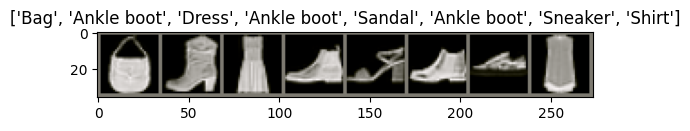

In [283]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    print(f"Input shape before transpose: {inp.shape}")
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    
    # Use the correct mean and std
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2471, 0.2435, 0.2616])
    
    # Reverse normalization
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # Clip values to [0, 1] for display
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))  # Use your actual train_loader here

# Make a grid from batch
print(f"Batch shape: {inputs.shape}")
print(f"Classes shape: {classes.shape}")
out = torchvision.utils.make_grid(inputs[:8])

# Display the images
imshow(out[:1], title=[class_names[x] for x in classes[:8]])


#### Training the Model

In [8]:
train_loss_fn = []
val_loss_fn = []
train_acc_fn = []
val_acc_fn = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_loss_fn.append(epoch_loss)
                    train_acc_fn.append(epoch_acc)
                else:
                    val_loss_fn.append(epoch_loss)
                    val_acc_fn.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    # Save accuracies and losses
    np.save('train_loss_fn.npy', train_loss_fn)
    np.save('val_loss_fn.npy', val_loss_fn)
    np.save('train_acc_fn.npy', train_acc_fn)
    np.save('val_acc_fn.npy', val_acc_fn)
    return model

#### Visualize predictions

In [360]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Finetuning the ConvNet

In [364]:
# Pretrained model
resnet18_model = resnet18(pretrained=True) 
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = resnet18_model.to(device)

lr_init = 0.001              # initial learning rate
lr_factor = 0.01             # learning rate decay factor
weight_decay_factor = 1e-4   # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate Model

In [365]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.1021 Acc: 0.7260
val Loss: 0.5568 Acc: 0.8607

Epoch 1/19
----------
train Loss: 0.3837 Acc: 0.9104
val Loss: 0.3207 Acc: 0.9091

Epoch 2/19
----------
train Loss: 0.2354 Acc: 0.9362
val Loss: 0.2889 Acc: 0.9080

Epoch 3/19
----------
train Loss: 0.1847 Acc: 0.9469
val Loss: 0.2354 Acc: 0.9235

Epoch 4/19
----------
train Loss: 0.1512 Acc: 0.9539
val Loss: 0.2701 Acc: 0.9136

Epoch 5/19
----------
train Loss: 0.1207 Acc: 0.9643
val Loss: 0.2348 Acc: 0.9243

Epoch 6/19
----------
train Loss: 0.1002 Acc: 0.9699
val Loss: 0.2348 Acc: 0.9278

Epoch 7/19
----------
train Loss: 0.0881 Acc: 0.9746
val Loss: 0.2425 Acc: 0.9264

Epoch 8/19
----------
train Loss: 0.0748 Acc: 0.9782
val Loss: 0.2132 Acc: 0.9380

Epoch 9/19
----------
train Loss: 0.0595 Acc: 0.9832
val Loss: 0.2622 Acc: 0.9237

Epoch 10/19
----------
train Loss: 0.0520 Acc: 0.9853
val Loss: 0.2384 Acc: 0.9305

Epoch 11/19
----------
train Loss: 0.0463 Acc: 0.9873
val Loss: 0.2487 Acc: 0.9298

Ep

Step 20


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

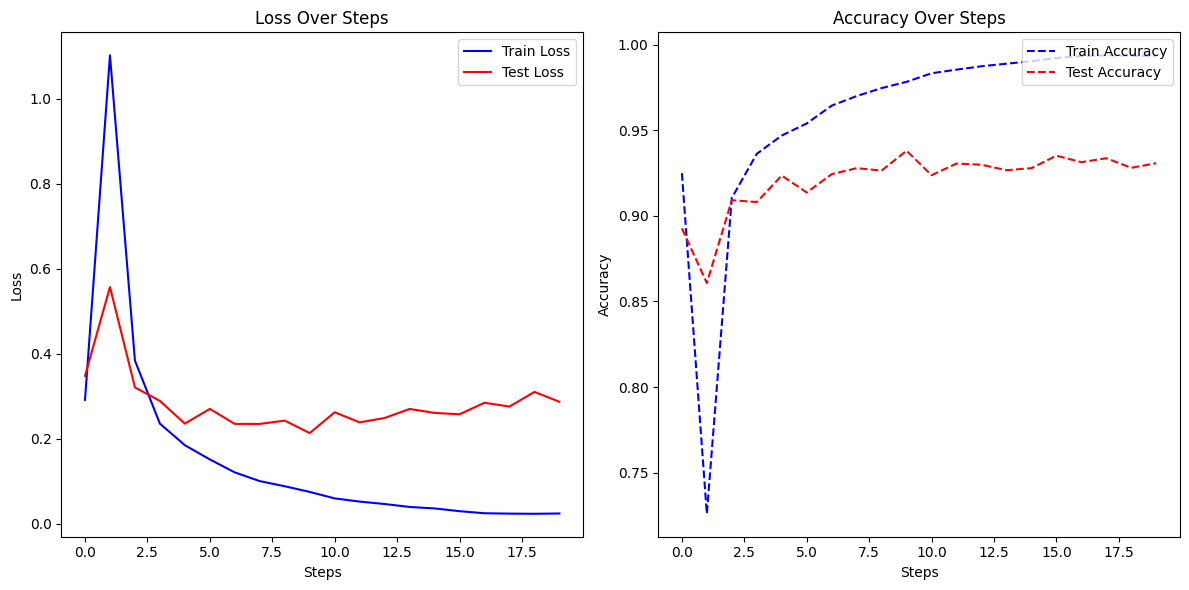

In [375]:
plot_loss_and_accuracy_side_by_side(train_loss_fn[:20], val_loss_fn[:20], train_acc_fn[:20], val_acc_fn[:20], range(20), 20)

In [376]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "Finetuned ResNet18"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(model_ft, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(model_ft, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100
Fashion-MNIST,Liniarized Images,MLP,Test,0.860365,0.861300,0.860445,0.861300
Fashion-MNIST,HOG-PCA20 Attributes,MLP,Test,0.830739,0.831500,0.830838,0.831500
Fashion-MNIST,Liniarized Images,Finetuned ResNet18,Test,0.937816,0.938000,0.937773,0.938000


In [377]:
results_df.to_csv('results.csv', index=False)

## Fruits-360

* **Fruits-360** is a dataset containing classes of fruits, vegetables, and nuts

* it contains 95k images made of 70 classes

* train: 71k; test: 24k

* every image has 70 attributes extracted using PCA with 70PC

In [61]:
import gc
import cv2

def getAllFruits():
    fruits = np.load('data/fruits-360/all_fruits.npy', allow_pickle=True)
    return fruits

fruits = getAllFruits()
print(fruits)
print(len(fruits))

['Mangostan' 'Cherry' 'Grape' 'Nectarine' 'Kohlrabi' 'Physalis' 'Carrot'
 'Melon' 'Tomato' 'Potato' 'Apple' 'Beetroot' 'Chestnut' 'Avocado' 'Pear'
 'Grapefruit' 'Kiwi' 'Nut' 'Cauliflower' 'Guava' 'Mulberry' 'Walnut'
 'Pineapple' 'Cucumber' 'Limes' 'Fig' 'Pepper' 'Onion' 'Kaki' 'Redcurrant'
 'Apricot' 'Banana' 'Peach' 'Zucchini' 'Granadilla' 'Maracuja'
 'Cantaloupe' 'Eggplant' 'Strawberry' 'Plum' 'Corn' 'Papaya' 'Mandarine'
 'Rambutan' 'Blueberry' 'Raspberry' 'Mango' 'Pitahaya' 'Tamarillo'
 'Cactus' 'Clementine' 'Huckleberry' 'Kumquats' 'Lemon' 'Hazelnut'
 'Quince' 'Dates' 'Watermelon' 'Cabbage' 'Pomelo' 'Carambula' 'Tangelo'
 'Cocos' 'Pepino' 'Pomegranate' 'Orange' 'Salak' 'Ginger' 'Passion'
 'Lychee']
70


### 1. MLP on extracted attributes

#### Load Data

In [496]:
# Load the dataset
train_images = np.load(f'./data/fruits-360/X_train_pca.npy')
test_images = np.load(f'./data/fruits-360/X_test_pca.npy')
y_train = np.load(f'./data/fruits-360/y_train.npy')
y_test = np.load(f'./data/fruits-360/y_test.npy')

# Normalize the data
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Size of training images torch.Size([71773, 70])
Size of training labels 71773
Size of test images torch.Size([24051, 70])
Size of test labels 24051


In [497]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=256, shuffle=True)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=256, shuffle=False)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of training images: torch.Size([256, 70])
Shape of training labels: torch.Size([256])
Shape of test images: torch.Size([256, 70])
Shape of test labels: torch.Size([256])


#### Define Model and Optimizers

In [499]:
net = None                       # type: nn.Module
mlp_model = MLP(num_classes=len(fruits), in_size=70)
    
mlp_model.train()               # Default after init is train
mlp_model = mlp_model.to(device)      # Move network to device

print(list(mlp_model.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_model(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

MLP(
  (fc1): Linear(in_features=70, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=70, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[ 0.0278,  0.0317,  0.1002, -0.0318, -0.1326,  0.0152, -0.1449,  0.0096,
         -0.0645, -0.1034,  0.1003, -0.0271,  0.0166,  0.0225,  0.1015,  0.1117,
         -0.1276,  0.1677, -0.0647, -0.0088, -0.1132, -0.0005,  0.0292,  0.0043,
          0.0030, -0.1109, -0.0202,  0.0133,  0.0266, -0.1590, -0.0630,  0.0781,
          0.0327, -0.0235, -0.0403,  0.1431,  0.0209,  0.1938,  0.1445,  0.0950,
         -0.0519,  0.0911, -0.0668,  0.0856,  0.0939, -0.0472,  0.1116, -0.0707,
          0.0260,  0.2116,  0.0774, -0.0911,  0.0796,  0.0682,  0.0028,  0.0608,
          0.0502,  0.0586,  0.1128, -0.0268,  0.0850,  0.0171, -0.1189, -0.0033,
          0.0669, -0.2338,  0.0099,  0.1335, -0.0640,  0.1761],
        [-0.0489, -0.1245,  0.2143, -0.0243, -0.1680, -0.0650, -0.16

In [500]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_model.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Test and Evaluate

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

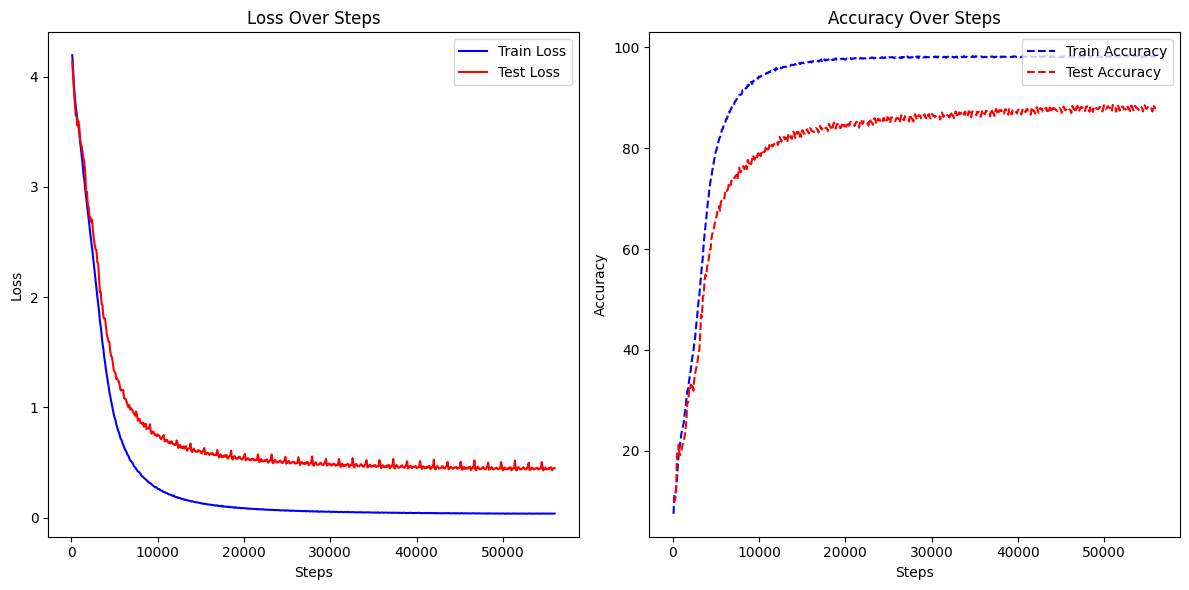

[200,   181,  56099] LR: 0.00001
[200,   181] loss: 0.03709, acc: 98.27344
[200,   181] avg_test_loss: 0.51885, avg_test_acc: 87.25
Step 56100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

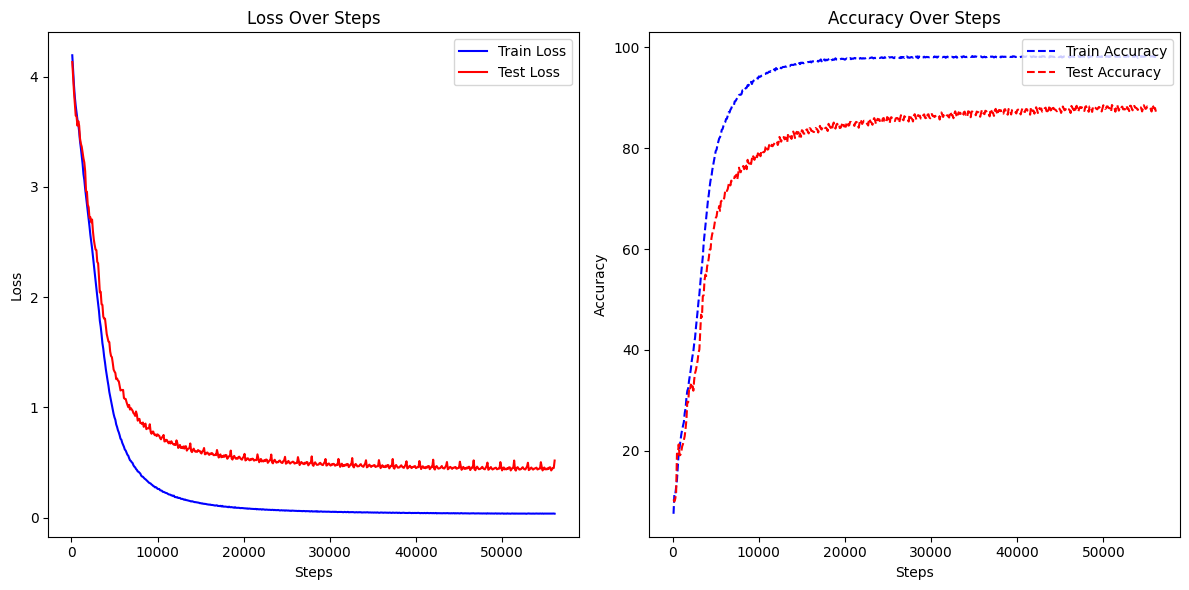

[200,   281,  56199] LR: 0.00001
[200,   281] loss: 0.03856, acc: 98.14646
[200,   281] avg_test_loss: 0.43666, avg_test_acc: 88.18
Finished Training


In [501]:
train_mlp(71773, 256, train_loader=train_loader, test_loader=test_loader,
        net=mlp_model, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [502]:
# Evaluate model
dataset_name = "Fruits-360"
input_type = "PCA70 Extracted Attributes"
model_name = "MLP"

# Calculate metrics for training and test sets
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_model, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_model, test_loader, device)

# Add results to table
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the full table
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100
Fashion-MNIST,Liniarized Images,MLP,Test,0.860365,0.861300,0.860445,0.861300
Fashion-MNIST,HOG-PCA20 Attributes,MLP,Test,0.830739,0.831500,0.830838,0.831500
Fashion-MNIST,Liniarized Images,Finetuned ResNet18,Test,0.937816,0.938000,0.937773,0.938000
Fruits-360,PCA70 Extracted Attributes,MLP,Test,0.884586,0.879880,0.879072,0.879880


In [503]:
results_df.to_csv('results2.csv', index=False)

### 2. MLP on images

#### Rescale images to 32x32

In [ ]:
# Scale images from 100x100 to 32x32
def resize_images(images, new_size=(32, 32)):
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1], images.shape[3]), dtype=np.uint8)
    for i in range(images.shape[0]):
        resized_image = cv2.resize(images[i].astype(np.uint8), new_size, interpolation=cv2.INTER_AREA)
        resized_images[i] = resized_image
    return resized_images

for fruit in fruits:
    # Paths for training and testing directories
    train_dir = f'./data/fruits-360/train/{fruit}'
    test_dir = f'./data/fruits-360/test/{fruit}'

    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Process training images ~
    X_train = np.load(f'./data/fruits-360/{fruit}_X_t.npy')
    X_train_resized = resize_images(X_train)
    print(f'{fruit} training images shape: {X_train_resized.shape}')
    
    # Save resized training images
    for idx, img in enumerate(X_train_resized):
        cv2.imwrite(os.path.join(train_dir, f'{fruit}_{idx}.jpg'), img)

    # Process testing images ~
    X_test = np.load(f'./data/fruits-360/{fruit}_X_testt.npy')
    X_test_resized = resize_images(X_test)
    print(f'{fruit} testing images shape: {X_test_resized.shape}')
    
    # Save resized testing images
    for idx, img in enumerate(X_test_resized):
        cv2.imwrite(os.path.join(test_dir, f'{fruit}_{idx}.jpg'), img)

    print(f'{fruit} images resized and saved in {train_dir} and {test_dir}')
    
    # Cleanup
    del X_train, X_train_resized, X_test, X_test_resized
    gc.collect()

#### Visualize Data

In [392]:
# Dataset image visualization
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

['Mangostan' 'Cherry' 'Grape' 'Nectarine' 'Kohlrabi' 'Physalis' 'Carrot'
 'Melon' 'Tomato' 'Potato']


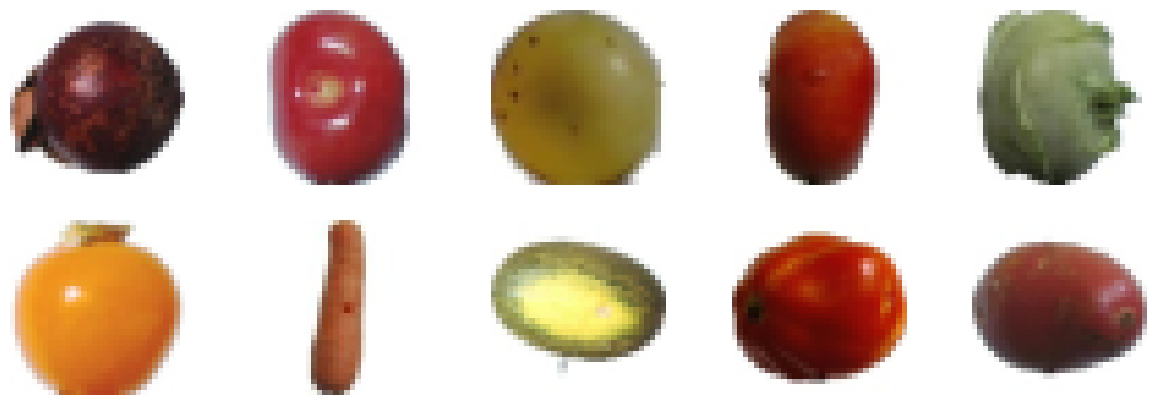

In [399]:
# Image plotting
images = []
fruits = getAllFruits()

images = []
for fruit in fruits[:10]:
    X_train = np.load(f'./data/fruits-360/{fruit}_X_train_resized.npy')
    images.append(X_train[0])
    del X_train

print(fruits[:10])
images = np.reshape(images, (len(fruits[:10]), 32, 32, 3))
plot_image_grid(images, 2, 5, figsize=(15, 5))
del images

#### Prepare Data

In [63]:
from torchvision import datasets, transforms

# Replace DATA_MEAN and DATA_STD with the calculated values
DATA_MEAN = (0.5, 0.5, 0.5)		# define the mean for the scaling transform - PIL images already come given in 
DATA_STD = (0.5, 0.5, 0.5)		# define the standard deviation for the scaling transform
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD),      # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to a 1D tensor
    ] 
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to a 1D tensor
    ] 
)

train_images = datasets.ImageFolder(root='./data/fruits-360/train', transform=train_transform)
test_images = datasets.ImageFolder(root='./data/fruits-360/test', transform=test_transform)

train_loader = DataLoader(train_images, batch_size=256, shuffle=True)
test_loader = DataLoader(test_images, batch_size=256, shuffle=False)

print(f'Size of training images {len(train_images)}')
print(f'Size of training labels {len(test_images)}')

Size of training images 71773
Size of training labels 24051


#### Define Model and Optimizers

In [64]:
net = None                       # type: nn.Module
mlp_model2 = MLP(num_classes=len(fruits), in_size=3072)
    
mlp_model2.train()               # Default after init is train
mlp_model2 = mlp_model2.to(device)      # Move network to device

print(list(mlp_model2.modules())[0])

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_model2(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

MLP(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=70, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[ 1.0426e-01,  7.9854e-02, -1.5404e-01,  5.0921e-02, -1.0074e-01,
          5.5198e-02, -2.4613e-01, -1.8293e-01, -2.3346e-02, -1.2083e-01,
         -1.0828e-01, -2.2755e-02,  8.4056e-02, -8.2529e-02, -2.4387e-02,
          2.5471e-02, -1.2341e-01,  1.3373e-01,  3.7474e-02,  3.5497e-02,
         -6.3833e-02, -1.8759e-01, -2.1494e-03, -5.1420e-02, -4.4759e-03,
         -1.1676e-02,  1.3160e-01, -5.9127e-02,  3.8877e-03,  1.2701e-01,
         -5.0231e-02, -3.3722e-02, -7.1854e-02, -3.7736e-02, -9.3058e-02,
          1.2048e-01,  1.0615e-01, -4.8665e-02,  6.8902e-02, -8.4394e-02,
          3.3340e-02, -4.9127e-02,  2.5678e-02,  1.1708e-01, -6.2227e-02,
          1.2625e-02,  1.5636e-02, -1.2035e-01,  2.6087e-02, -3.2812e-02,
          5.5981e-02, -5.3816e-02,  1.

In [65]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_model2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_model2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

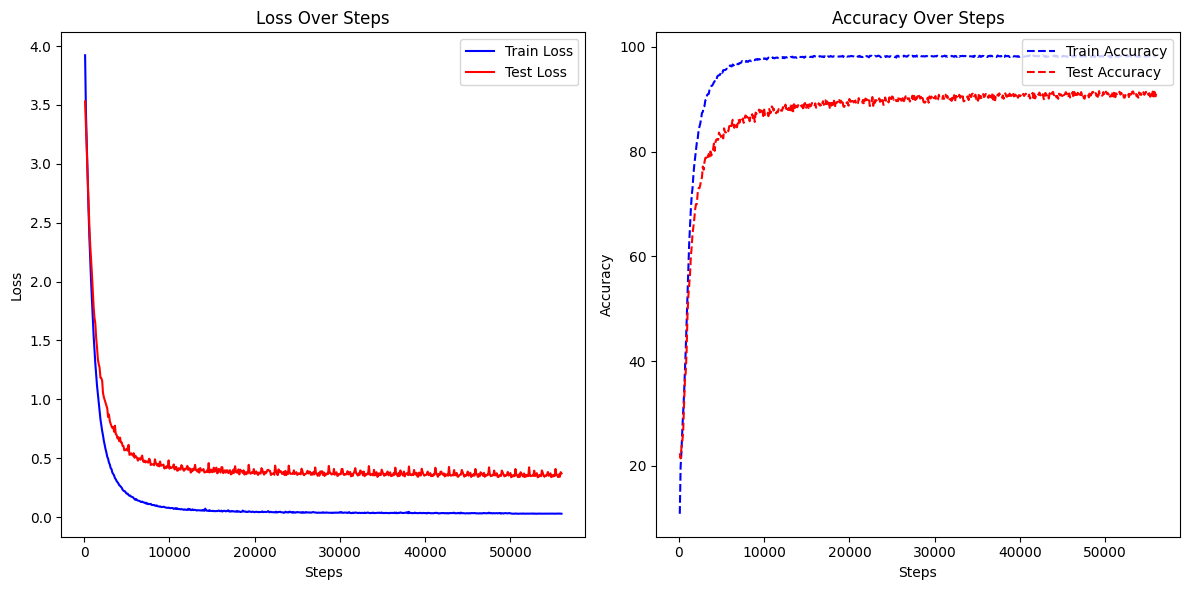

[200,   181,  56099] LR: 0.00010
[200,   181] loss: 0.02900, acc: 98.31250
[200,   181] avg_test_loss: 0.35266, avg_test_acc: 91.01
Step 56100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

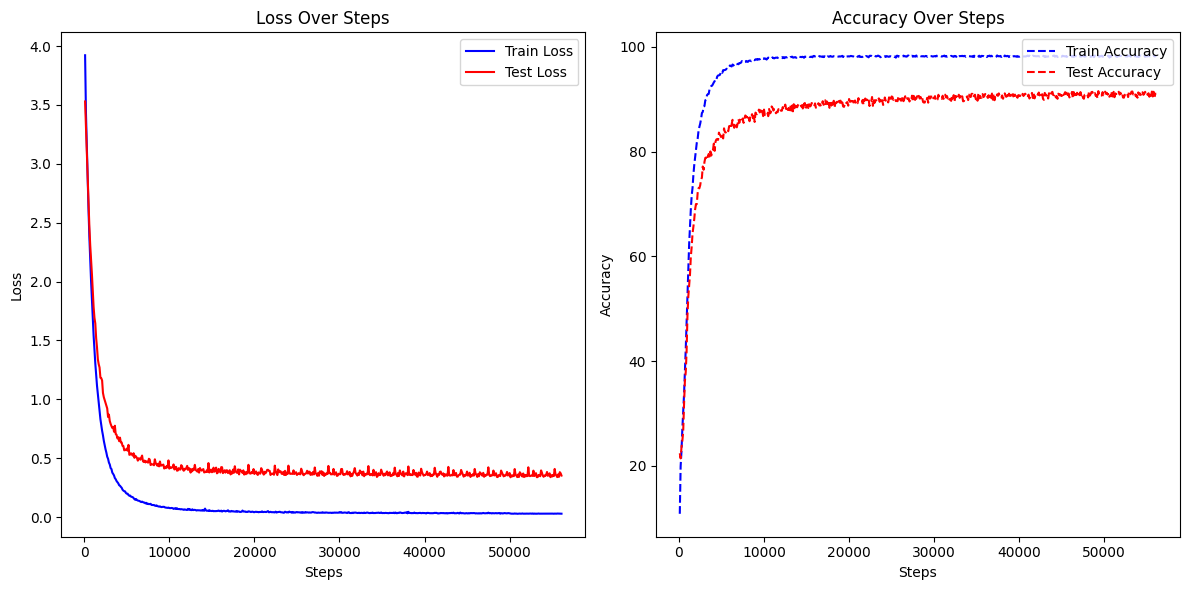

[200,   281,  56199] LR: 0.00010
[200,   281] loss: 0.02985, acc: 98.16503
[200,   281] avg_test_loss: 0.34586, avg_test_acc: 91.25
Finished Training


In [66]:
train_mlp(71773, 256, train_loader=train_loader, test_loader=test_loader,
        net=mlp_model2, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [67]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fruits-360"
input_type = "Linearized Images"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_model2, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_model2, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,MLP,Test,0.890001,0.890500,0.889791,0.890500
Fashion-MNIST,Liniarized Images,LeNet-5 wihout Augmentation,Test,0.906556,0.906300,0.906148,0.906300
Fashion-MNIST,Liniarized Images,LeNet-5 with Augmentation,Test,0.875513,0.875500,0.875132,0.875500
Fruits-360,Linearized Images,MLP,Test,0.906131,0.909359,0.901127,0.909359


In [68]:
results_df.to_csv('results2.csv', index=False)

### 3. DeepConvNet on Images

#### Load Data without Augmentation

In [80]:
from torchvision import datasets, transforms

DATA_MEAN = (0.5, 0.5, 0.5)		# define the mean for the scaling transform - PIL images already come given in 
DATA_STD = (0.5, 0.5, 0.5)		# define the standard deviation for the scaling transform
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD)      # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std
    ] 
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD)
    ] 
)

# Load data
train_images = datasets.ImageFolder(root='./data/fruits-360/train', transform=train_transform)
test_images = datasets.ImageFolder(root='./data/fruits-360/test', transform=test_transform)

train_loader = DataLoader(train_images, batch_size=256, shuffle=True)
test_loader = DataLoader(test_images, batch_size=256, shuffle=False)

print(f'Size of training images {len(train_images)}')
print(f'Size of training labels {len(test_images)}')

Size of training images 71773
Size of training labels 24051


#### Load Data with Augmentation

In [90]:
from torchvision import datasets, transforms

# Replace DATA_MEAN and DATA_STD with the calculated values
DATA_MEAN = (0.5, 0.5, 0.5)		# define the mean for the scaling transform - PIL images already come given in 
DATA_STD = (0.5, 0.5, 0.5)		# define the standard deviation for the scaling transform
train_transform_aug = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(30),
        transforms.RandomCrop(                          # apply random crop, after padding image with 4 values on each side, using `reflect` mode
            size=(32, 32), 
            padding=(4, 4), 
            padding_mode="reflect"),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD)      # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    ] 
)


test_transform_aug = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD)
    ] 
)

train_images_aug = datasets.ImageFolder(root='./data/fruits-360/train', transform=train_transform_aug)
test_images_aug = datasets.ImageFolder(root='./data/fruits-360/test', transform=test_transform_aug)

train_loader_aug = DataLoader(train_images, batch_size=256, shuffle=True)
test_loader_aug = DataLoader(test_images, batch_size=256, shuffle=False)

print(f'Size of training images {len(train_images)}')
print(f'Size of training labels {len(test_images)}')

Size of training images 71773
Size of training labels 24051


#### Define Model and Optimizers

In [91]:
# model
net = None                       # type: nn.Module
net = LeNet(num_classes=len(fruits), in_channels=3)
net_aug = LeNet(num_classes=len(fruits), in_channels=3)
    
net.train()               # Default after init is train
net = net.to(device)      # Move network to device

print(list(net.modules())[0])

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))
(batch_train_images_aug, batch_train_labels_aug) = next(iter(train_loader_aug))

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

LeNet(
  (feature): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=120, out_features=70, bias=True)
  )
)
tensor([[ 0.0935,  0.0200,  0.1004,  0.1060, -0.0255,  0.1045,  0.0184,  0.0978,
         -0.0839,  0.0758,  0.0172, -0.0206, -0.0698, -0.0263, -0.1198,  0.0744,
          0.0734,  0.0410, -0.1446, -0.0528, -0.0367, -0.1002, -0.0269,  0.0236,
          0.0435, -0.1126, -0.0190,  0.0690,  0.0464,  0.0708,  0.0047,  0.0357,
          0.0472,  0.0373,  0.0253, -0

In [92]:
lr_init = 0.001             # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.Adam(net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate Model without Augmentation

In [84]:
train_losses, train_accuracies, test_losses, test_accuracies, steps = train_lenet(71773, 256, train_loader=train_loader, test_loader=test_loader,
         net=net, lr_scheduler=lr_scheduler, optimizer=optimizer)

[1,   100,     99] LR: 0.00100
[1,   100] loss: 3.06067, acc: 20.60156
[1,   100] avg_test_loss: 2.22419, avg_test_acc: 33.74
[1,   200,    199] LR: 0.00100
[1,   200] loss: 1.93670, acc: 42.24219
[1,   200] avg_test_loss: 1.63619, avg_test_acc: 53.32
[2,    19,    299] LR: 0.00100
[2,    19] loss: 1.46112, acc: 56.82959
[2,    19] avg_test_loss: 1.38983, avg_test_acc: 60.70
[2,   119,    399] LR: 0.00100
[2,   119] loss: 1.17952, acc: 64.83984
[2,   119] avg_test_loss: 1.33379, avg_test_acc: 62.63
[2,   219,    499] LR: 0.00100
[2,   219] loss: 1.02336, acc: 69.23828
[2,   219] avg_test_loss: 1.27781, avg_test_acc: 67.91
[3,    38,    599] LR: 0.00100
[3,    38] loss: 0.89241, acc: 72.72720
[3,    38] avg_test_loss: 1.08672, avg_test_acc: 69.56
[3,   138,    699] LR: 0.00100
[3,   138] loss: 0.80500, acc: 75.33203
[3,   138] avg_test_loss: 1.04390, avg_test_acc: 71.34
[3,   238,    799] LR: 0.00100
[3,   238] loss: 0.72994, acc: 77.39062
[3,   238] avg_test_loss: 1.05215, avg_test_acc

Step 56199


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

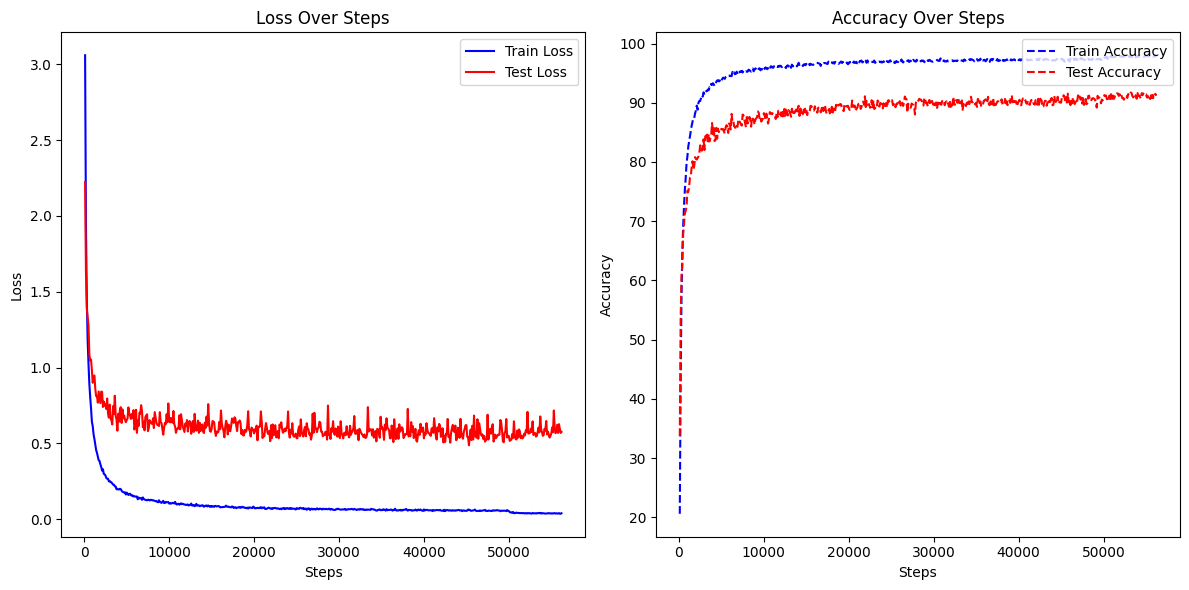

In [85]:
plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracies, test_accuracies, steps, steps[-1])

In [86]:
np.save('lenet_without_aug_losses.npy', [train_losses, train_accuracies, test_losses, test_accuracies, steps])

In [87]:
# Evaluate model
dataset_name = "Fruits-360"
input_type = "Linearized Images without Augmentation"
model_name = "LeNet-5"

# Calculate metrics for training and test sets
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(net, test_loader, device)

# Add results to table
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the full table
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,MLP,Test,0.890001,0.890500,0.889791,0.890500
Fashion-MNIST,Liniarized Images,LeNet-5 wihout Augmentation,Test,0.906556,0.906300,0.906148,0.906300
Fashion-MNIST,Liniarized Images,LeNet-5 with Augmentation,Test,0.875513,0.875500,0.875132,0.875500
Fruits-360,Linearized Images,MLP,Test,0.906131,0.909359,0.901127,0.909359
Fruits-360,Linearized Images without Augmentation,LeNet-5,Test,0.908242,0.910232,0.903275,0.910232


In [88]:
results_df.to_csv('results2.csv', index=False)

#### Train and Evaluate Model with Augmentation

In [ ]:
train_losses_aug, train_accuracy_aug, test_losses_aug, test_accuracy_aug, steps_aug = train_lenet(71773, 256, train_loader=train_loader_aug, test_loader=test_loader_aug,
         net=net, lr_scheduler=lr_scheduler, optimizer=optimizer)

[1,   100,     99] LR: 0.00100
[1,   100] loss: 3.12832, acc: 20.30469
[1,   100] avg_test_loss: 2.28322, avg_test_acc: 31.81
[1,   200,    199] LR: 0.00100
[1,   200] loss: 1.94012, acc: 42.16016
[1,   200] avg_test_loss: 1.71671, avg_test_acc: 51.52
[2,    19,    299] LR: 0.00100
[2,    19] loss: 1.45173, acc: 56.24572
[2,    19] avg_test_loss: 1.53449, avg_test_acc: 55.40
[2,   119,    399] LR: 0.00100
[2,   119] loss: 1.18522, acc: 64.57422
[2,   119] avg_test_loss: 1.43461, avg_test_acc: 61.68
[2,   219,    499] LR: 0.00100
[2,   219] loss: 0.99839, acc: 69.50781
[2,   219] avg_test_loss: 1.34546, avg_test_acc: 63.59
[3,    38,    599] LR: 0.00100
[3,    38] loss: 0.86902, acc: 74.03293
[3,    38] avg_test_loss: 1.14369, avg_test_acc: 69.00
[3,   138,    699] LR: 0.00100
[3,   138] loss: 0.76428, acc: 76.61328
[3,   138] avg_test_loss: 1.13581, avg_test_acc: 69.64
[3,   238,    799] LR: 0.00100
[3,   238] loss: 0.68225, acc: 79.15625
[3,   238] avg_test_loss: 1.04286, avg_test_acc

In [ ]:
plot_loss_and_accuracy_side_by_side(train_losses_aug, test_losses_aug, train_accuracy_aug, test_accuracy_aug, steps_aug, steps_aug[-1])

In [ ]:
np.save('lenet_with_aug_losses.npy', [train_losses_aug, train_accuracy_aug, test_losses_aug, test_accuracy_aug, steps_aug])

In [ ]:
# Evaluate model
dataset_name = "Fruits-360"
input_type = "Linearized Images with Augmentation"
model_name = "LeNet-5"

# Calculate metrics for training and test sets
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(net, train_loader_aug, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(net, test_loader_aug, device)

# Add results to table
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the full table
results_df.style.hide()

In [ ]:
results_df.to_csv('results2.csv', index=False)

#### Plot Comparative Results

In [ ]:
plot_comparative_results(train_losses, test_losses, train_accuracies, test_accuracies, steps,
                            train_losses_aug, test_losses_aug, train_accuracy_aug, test_accuracy_aug, steps_aug)

### 4. Finetune Pretrained Models

#### Load Data

In [12]:
# import the necessary packages
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),     # Convert to tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])  # Normalize for RGB channels
])

# Load the dataset
train_images = datasets.ImageFolder(root='./data/fruits-360/train', transform=transform)
test_images = datasets.ImageFolder(root='./data/fruits-360/test', transform=transform)

train_loader = DataLoader(train_images, batch_size=256, shuffle=True)
test_loader = DataLoader(test_images, batch_size=256, shuffle=False)

print(f'Size of training images {len(train_images)}')
print(f'Size of training labels {len(test_images)}')



Size of training images 71773
Size of training labels 24051


In [13]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_images), 'val': len(test_images)}
print(dataset_sizes)

{'train': 71773, 'val': 24051}


#### Define Model and Optimizer

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory
from PyTorch_CIFAR10.cifar10_models.resnet import resnet18

In [23]:
# Pretrained model
resnet18_model = resnet18(pretrained=True) 
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, len(fruits))

model_ft = resnet18_model.to(device)

lr_init = 0.001              # initial learning rate
lr_factor = 0.01             # learning rate decay factor
weight_decay_factor = 1e-4   # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 3.0598 Acc: 0.3462
val Loss: 2.3846 Acc: 0.4549

Epoch 1/19
----------
train Loss: 1.9598 Acc: 0.5392
val Loss: 1.7917 Acc: 0.5749

Epoch 2/19
----------
train Loss: 1.5247 Acc: 0.6257
val Loss: 1.4201 Acc: 0.6716

Epoch 3/19
----------
train Loss: 1.1515 Acc: 0.7211
val Loss: 1.0618 Acc: 0.7431

Epoch 4/19
----------
train Loss: 0.7580 Acc: 0.8638
val Loss: 0.6387 Acc: 0.9252

Epoch 5/19
----------
train Loss: 0.3775 Acc: 0.9671
val Loss: 0.3301 Acc: 0.9601

Epoch 6/19
----------
train Loss: 0.1813 Acc: 0.9777
val Loss: 0.2105 Acc: 0.9649

Epoch 7/19
----------
train Loss: 0.1134 Acc: 0.9797
val Loss: 0.1663 Acc: 0.9682

Epoch 8/19
----------
train Loss: 0.0816 Acc: 0.9824
val Loss: 0.1415 Acc: 0.9682

Epoch 9/19
----------
train Loss: 0.0658 Acc: 0.9818
val Loss: 0.1308 Acc: 0.9682

Epoch 10/19
----------
train Loss: 0.0567 Acc: 0.9812
val Loss: 0.1181 Acc: 0.9692

Epoch 11/19
----------
train Loss: 0.0507 Acc: 0.9819
val Loss: 0.1121 Acc: 0.9689

Ep

Step 20


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

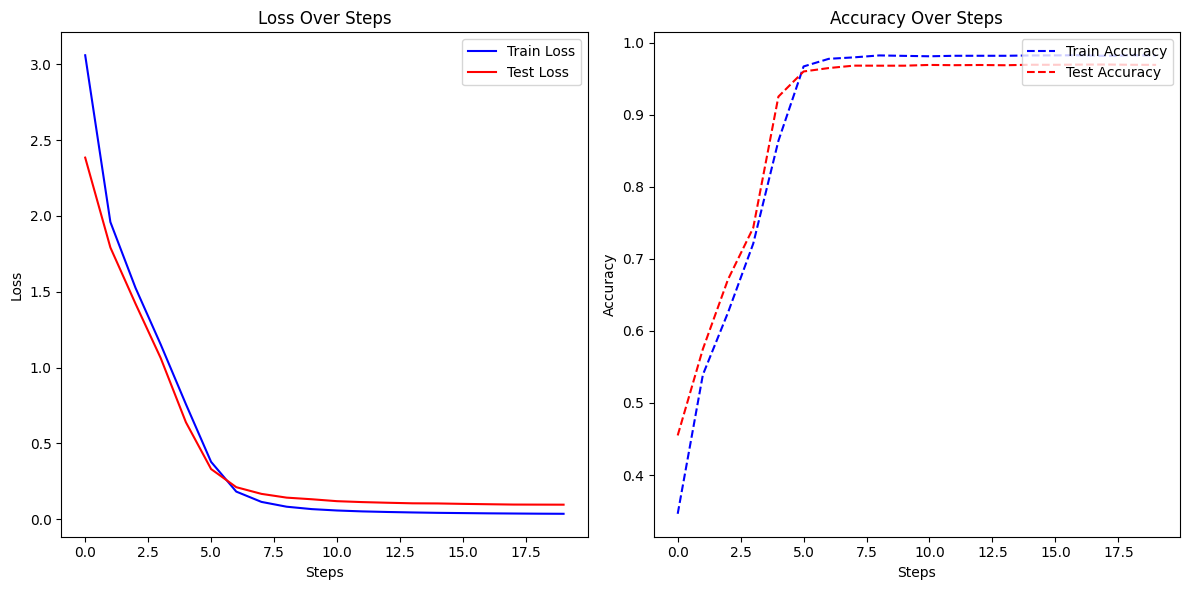

In [27]:
plot_loss_and_accuracy_side_by_side(train_loss_fn[:20], val_loss_fn[:20], train_acc_fn[:20], val_acc_fn[:20], range(20), 20)

In [28]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fruits-360"
input_type = "Liniarized Images"
model_name = "Finetuned ResNet18"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(model_ft, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(model_ft, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fruits-360,Liniarized Images,Finetuned ResNet18,Test,0.975405,0.969773,0.969195,0.969773


In [29]:
results_df.to_csv('results2.csv', index=False)